## Data Processing

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd

In [2]:
stores = pd.read_csv('map_parser/processed-c-stores.csv')
filtered_stores = stores[stores['candidates'] == 1]
filtered_stores.head(5)

,Unnamed: 0,公司統一編號,公司名稱,分公司統一編號,分公司名稱,分公司地址,分公司狀態,company,label,lat,lng,candidates
1,1,22555003,統一超商股份有限公司,16080140,台北巿第三四二分公司,臺北市松山區健康路224號１樓,1,7-ELEVEN,1,25.053838,121.561100,1.0
2,2,22555003,統一超商股份有限公司,16080155,台北縣第２５５分公司,新北市三峽區永館里９鄰民生街１０２號１樓,3,7-ELEVEN,0,24.935585,121.373837,1.0
3,3,22555003,統一超商股份有限公司,16080161,台北縣第２５６分公司,新北市三峽區鳶山里十二鄰中山路１８６號１樓,1,7-ELEVEN,1,24.936885,121.363857,1.0
4,4,22555003,統一超商股份有限公司,16080177,新竹市第２６分公司,新竹市民富里７鄰北大路３４２號,1,7-ELEVEN,1,24.805845,120.961708,1.0
5,5,22555003,統一超商股份有限公司,16080182,新竹市第２７分公司,新竹巿新民里北大路２８６號,3,7-ELEVEN,0,24.807167,120.963422,1.0


In [3]:
sample = filtered_stores.iloc[0]

### Regular Map Tile

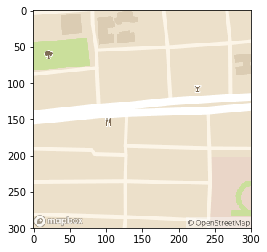

In [4]:
img = mpimg.imread('map_parser/maps/{}.png'.format(sample['分公司統一編號']))
imgplot = plt.imshow(img)

### Traffic Map Tile

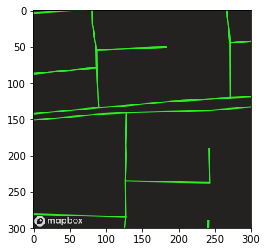

In [5]:
img = mpimg.imread('map_parser/maps-traffic/{}.png'.format(sample['分公司統一編號']))
imgplot = plt.imshow(img)

### Prepare Training/Testing Data

In [18]:
import os

from keras.preprocessing.image import img_to_array, load_img
from PIL import Image
from sklearn.utils import shuffle

def preprocess_image(invoice):
#     regular_map = load_img('map_parser/maps/{}.png'.format(invoice)).resize((128, 128), Image.BILINEAR)
    traffic_map = load_img('map_parser/maps-traffic/{}.png'.format(invoice)).resize((128, 128), Image.BILINEAR)
#     x = np.dstack((img_to_array(regular_map), img_to_array(traffic_map)))

    return img_to_array(traffic_map)

def load_data_generator(X, Y, batch_size=64):
    maps = os.listdir('map_parser/maps')
    traffic_maps = os.listdir('map_parser/maps-traffic')

    num_samples = X.shape[0]
    while True:
        try:
            for i in range(0, num_samples, batch_size):
                x_data = [preprocess_image(invoice) for invoice in X[i:i+batch_size]]
                x_data = np.array(x_data)
                x_data = x_data.astype('float32') / 255
                y_data = Y[i:i + batch_size]

                yield shuffle(x_data, np.array(y_data))

        except Exception as err:
            print(err)

int() argument must be a string, a bytes-like object or a number, not 'Image'
int() argument must be a string, a bytes-like object or a number, not 'Image'
int() argument must be a string, a bytes-like object or a number, not 'Image'
int() argument must be a string, a bytes-like object or a number, not 'Image'
int() argument must be a string, a bytes-like object or a number, not 'Image'
float() argument must be a string or a number, not 'Image'
float() argument must be a string or a number, not 'Image'


In [7]:
invoices = filtered_stores['分公司統一編號']
labels = filtered_stores['label']

In [8]:
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    invoices, labels, test_size=0.2, random_state=42, stratify=labels)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=42, stratify=y_train)

encoded_y_train = y_train
encoded_y_val = y_val
encoded_y_test = y_test

# encoded_y_train = to_categorical(y_train, num_classes=2, dtype='float32')
# encoded_y_val = to_categorical(y_val, num_classes=2, dtype='float32')
# encoded_y_test = to_categorical(y_test, num_classes=2, dtype='float32')

## Model Building

In [9]:
from keras.applications.mobilenetv2 import MobileNetV2
from keras.layers import Dense, Input, Dropout
from keras.models import Model

In [15]:
def build_model(target_size, channel_size=3):
    input_tensor = Input(shape=(target_size, target_size, channel_size))
    base_model = MobileNetV2(
        include_top=False,
        weights=None,
        input_tensor=input_tensor,
        input_shape=(target_size, target_size, channel_size),
        pooling='avg')

    for layer in base_model.layers:
        layer.trainable = True  # trainable has to be false in order to freeze the layers
        
    op = Dense(256, activation='relu')(base_model.output)
    op = Dropout(.25)(op)
    
    ##
    # softmax: calculates a probability for every possible class.
    #
    # activation='softmax': return the highest probability;
    # for example, if 'Coat' is the highest probability then the result would be 
    # something like [0,0,0,0,1,0,0,0,0,0] with 1 in index 5 indicate 'Coat' in our case.
    ##
    output_tensor = Dense(1, activation='softmax')(op)

    model = Model(inputs=input_tensor, outputs=output_tensor)

    return model

In [16]:
from keras.optimizers import Adam

model = build_model(128)
model.compile(optimizer=Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

## Model Training

In [19]:
train_generator = load_data_generator(X_train, encoded_y_train, batch_size=32)

model.fit_generator(
    generator=train_generator,
    steps_per_epoch=500,
    verbose=1,
    validation_data=load_data_generator(X_val, encoded_y_val, batch_size=32),
    nb_val_samples=100,
    epochs=50
)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:9: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  if __name__ == '__main__':
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(validation_steps=100, generator=<generator..., validation_data=<generator..., steps_per_epoch=500, verbose=1, epochs=50)`
  if __name__ == '__main__':


Epoch 1/50
500/500 [==============================] - 64s 128ms/step - loss: 6.0448 - acc: 0.6208 - val_loss: 6.0897 - val_acc: 0.6180
Epoch 2/50
500/500 [==============================] - 52s 105ms/step - loss: 6.0040 - acc: 0.6234 - val_loss: 6.0079 - val_acc: 0.6232
Epoch 3/50
500/500 [==============================] - 53s 105ms/step - loss: 6.0505 - acc: 0.6205 - val_loss: 6.0197 - val_acc: 0.6224
Epoch 4/50
500/500 [==============================] - 53s 106ms/step - loss: 6.0119 - acc: 0.6229 - val_loss: 6.0680 - val_acc: 0.6194
Epoch 5/50
500/500 [==============================] - 53s 106ms/step - loss: 5.9927 - acc: 0.6241 - val_loss: 5.9846 - val_acc: 0.6246
Epoch 6/50
472/500 [===========================>..] - ETA: 2s - loss: 6.0477 - acc: 0.6207

KeyboardInterrupt: 